# Tutorial 1 - WaveBot
The goal of this tutorial is to show a simple example of the inner optimization loop in WecOptTool. 
It uses a one-body WEC, the WaveBot, in one degree of freedom in regular waves. 
The goal is to **find the optimal PTO force time-series** that produce the most energy subject to a maximum force the PTO can excert.

![WaveBot Photo](https://live.staticflickr.com/65535/51855905347_de87ccaaba_z.jpg)

We will start by loading the necessary modules and creating a save directory:

* Set the [logging level](https://docs.python.org/3/library/logging.html#levels) (optional) to control the amount of information printed to the screen
* Import Autograd (wrapper on NumPy, required) for automatic differentiation
* Import other packages we will use in this tutorial 
* Import WecOptTool 
* Create the *save* directory if it doesn't exist
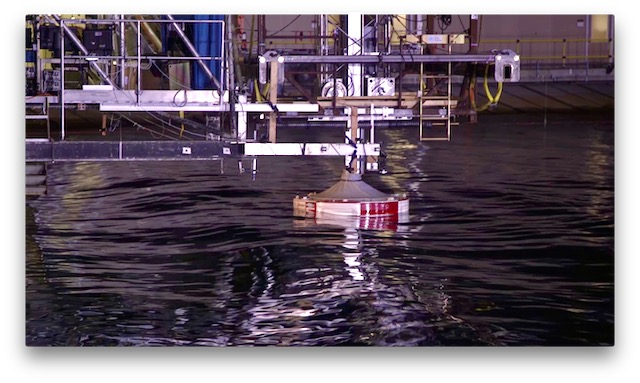

In [1]:
import autograd.numpy as np
import capytaine as cpy
import matplotlib.pyplot as plt

# wecopttool
import wecopttool as wot

# create save directory
import os
results_dir = 'results_tutorial_1'
if not os.path.exists(results_dir):
  os.makedirs(results_dir)

## Problem setup
The problem is defined in three parts: the WEC object, the wave spectrum, and the objective function that we are optimizing for. 

### WEC object
In this section we will create the `WEC` object, which contains all the information about the WEC and its dynamics.
This includes the mesh, degrees of freedom, mass and hydrostatic properties, linear hydrodynamic coefficients (from a BEM solution), additional dynamic forces (e.g. PTO force, mooring, non-linear hydrodynamics), and constraints (e.g. maximum PTO extension). 
In this case, the only additional force will be the PTO force and the only constraint will be a maximum PTO force of $2000 N$.
Note that the BEM solution is not required when creating the WEC object, it can be calculated or read after the WEC is created.
WecOptTool uses Capytaine as a BEM solver, and one of the first things we will do is create a Capytaine FloatingBody. 

First, we will create a surface mesh for the hull using an existing function (note, you can use existing STL files, etc.).

In [2]:
wb = wot.geom.WaveBot()  # use standard dimensions
mesh_size_factor = 0.5 # 1.0 for default, smaller to refine mesh
mesh = wb.mesh(mesh_size_factor)

From this mesh, we can create a Capytaine floating body, which captures both the mesh and degrees of freedom. We will only model the heave degree of freedom in this case.

In [3]:
fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
fb.add_translation_dof(name="Heave")
ndof = 1

INFO:capytaine.bodies.bodies:Stored 1042 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: WaveBot.


At this point we can visualize the mesh for inspection.
Capytaine has built-in methods for visualizing meshes (`fb.show`, and `fb.show_matplotlib`). 
When running outside a Notebook, these are interactive.  
The included WaveBot example also has a method for plotting the cross-section of the device. 

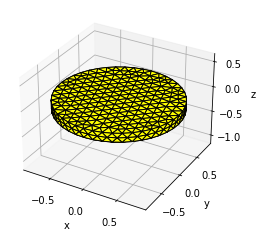

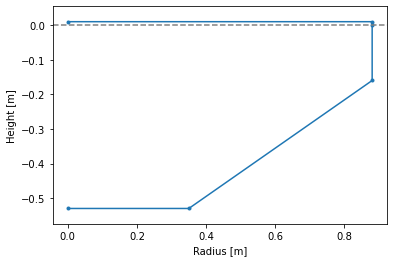

In [4]:
fb.show_matplotlib()
_ = wb.plot_cross_section(show=True)  # specific to WaveBot

Next we will add the mass (plus inertia) and hydrostatic stiffness properties. 
If these values are known they can be added directly.
Here we will use the fact that the WaveBot is free floating and assume constant density to calculate these properties, which Capytaine can natively perform with the `FloatingBody` created above. For convenience, this functionality has been wrapped in `wecopttool.hydrostatics`.

In [5]:
stiffness = wot.hydrostatics.stiffness_matrix(fb).values
mass = wot.hydrostatics.inertia_matrix(fb).values

INFO:wecopttool.hydrostatics:Using the geometric centroid as the center of gravity (COG).
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:wecopttool.hydrostatics:Setting the mass to the displaced mass.


Next, we will define the frequencies to be considered for the pseudo-spectral problem. 
We will use 50 frequencies with a spacing of 0.05 Hz. 
These frequencies will be used for the Fourier representation of both the wave (and wave excitation force, BEM) and the desired PTO force. 
See the Theory section of the Documentation for more details on the pseudo-spectral problem formulation.
(TODO this can be made more succinct I think)

BEM stuff TODO

In [6]:
f1 = 0.05
nfreq = 50
freq = wot.frequency(f1, nfreq, False)

# bem
hydro_data_file_name = 'tutorial_1_wavebot_hydro_data.nc'

# if not os.path.exists(hydro_data_file_name):
bem = wot.run_bem(fb, freq)
wot.write_netcdf(fpath=hydro_data_file_name, data=bem,)

INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.314, depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.314, depth=inf, radiating_dof=Heave, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.628, depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.628, depth=inf, radiating_dof=Heave, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.942, depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.942, depth=inf, radiating_dof=Heave, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=1.257, depth=inf,

In general, the optimization state and objective function can be anything of interest, and the additional dynamic forces and constraint are also arbitrary. 
In this case the optimization state is the PTO force time-history (Fourier representation), the PTO force will be used as an additional force in the dynamics and will be constrained, and the average PTO power will be the optimization objective function. WecOptTool includes these functions for this specific case in the `wecopttool.pto` submodule -- you will have to write your own functions for different optimization states, functions, and constraint definitions.

We will start by creating an instance of the `PTO` class, which requires:
- The kinematics matrix, which converts from the WEC degrees of freedom to the PTO degrees of freedom. The PTO extracts power directly from the WEC's heave in this case, so the kinematics matrix is simply the $1 \times 1$ identity matrix.
- The definition of the PTO controller. The `wecopttool.pto` submodule includes P, PI, and PID controller functions that can be provided to the `PTO` class and return the PTO force. However, we will be using an unstructured controller in this case, so we will set `None` for the controller.
- Any PTO impedance (defined below) TODO expand this point
- The power conversion efficiency (assumed 100% if `None`)
- The PTO system name (optional)

In [7]:
## PTO impedance definition
omega = bem.omega.values
gear_ratio = 12.0
torque_constant = 6.7
winding_resistance = 0.5
winding_inductance = 0.0
drivetrain_inertia = 2.0
drivetrain_friction = 1.0
drivetrain_stiffness = 0.0

drivetrain_impedance = (1j*omega*drivetrain_inertia + 
                        drivetrain_friction + 
                        1/(1j*omega)*drivetrain_stiffness) 

winding_impedance = winding_resistance + 1j*omega*winding_inductance


pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape) 
pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_22 = winding_impedance
pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                        [pto_impedance_21, pto_impedance_22]])

## PTO class definition
name = ["PTO_Heave",]
kinematics = np.eye(ndof)
efficiency = None
controller = None
pto = wot.pto.PTO(ndof, kinematics, controller, pto_impedance, efficiency, name)

Next we will create the constraints, which must be in the correct format for [`scipy.optimize.minimize()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). 
We will constraint the PTO force to $2000 N$ in either direction. 
We will enforce the constraint at 4 times more points than the dynamics (see theory section for why this is helpful for the pseudo-spectral problem). 
This will be the only constraint.

We will also create the additional dynamics forces function, which will simply be the PTO force.

In [8]:
# constraints
f_max = 2000.0
nsubsteps = 4

def const_f_pto(wec, x_wec, x_opt, waves):
    f = pto.force_on_wec(wec, x_wec, x_opt, nsubsteps)
    return f_max - np.abs(f.flatten())

ineq_cons = {'type': 'ineq',
             'fun': const_f_pto,
             }
constraints = [ineq_cons]

# additional dynamics forces function
f_add = {'PTO': pto.force_on_wec}
fric = None


We are now ready to create the WEC object! We can define the object using the `wecopttool.WEC.from_bem` function pointing to the NetCDF file containing the BEM results calculated above. The function also accepts an `xarray.Dataset` of Capytaine BEM results directly, but the sign convention of the data must be altered to work with WecOptTool -- see the docstring for `from_bem` for more details.

In [9]:
wec = wot.WEC.from_bem(hydro_data_file_name,
                    inertia_matrix=mass,
                    hydrostatic_stiffness=stiffness,
                    constraints=constraints,
                    friction=None,
                    f_add=f_add,
                    )

### Waves
The wave environment must be specified as an `xarray.Dataset` containing two 2-dimensional `xarray.DataArray`: (1) the amplitude spectrum  magnitude ``S``
(m^2*s) and (2) the phase ``phase`` (rad). 
The two coordinates are the wave frequency ``omega`` (rad/s)  and the direction ``wave_direction`` (rad). 
The `wecopttool.waves` submodule contains functions for creating this `xarray.Dataset` for different types of wave environments. 

In this case we will use a regular wave with a frequency of 0.3 Hz and an amplitude of 0.0625 m. 
We will use the `wecopttool.waves.regular_wave` function. 

Now we may create a regular wave using the `wecopttool.waves` submodule. In this case, we will use a wave with a frequency of 0.3 Hz and an amplitude of 0.0625 m.

In [10]:
amplitude = 0.0625  
wavefreq = 0.3
phase = 30
wavedir = 0
waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)

### Objective function
The objective function is the quantity (scalar) we want to optimize. 
It is function of both the WEC dynamics state and the user-defined optimization state. 
We will need to give the solver the objective function to optimize and the size of the optimization state. 
In this case these are the average PTO power and the number of Fourier coefficients in the pseudo-spectral representation of the PTO force, respectively. 
We can get both of these from the PTO object we created.

In [11]:
obj_fun = pto.average_power
ncomponents_pto = 2*nfreq+1

## Solve
Now we can solve for the optimal PTO force, subject to the dynamics and our additional constraint (no more than $2000 N$ force). 
WecOptTool will solve the optimization problem (PTO force that will produce the highest average power) while simultaneously ensuring the dynamics equation is satisfied.

We are now ready to solve the problem. 
Note that we can pass additional options to the optimizer. 
For more details see `scipy.optimize.minimize`. 
Also note that the only required inputs for defining and solving the problem are: (1) the waves, (2) the objective function, and (3) the size of the optimization state. 
All other inputs are used to control the optimization execution. 
Pay attention to the `Exit mode`: an exit mode of $0$ indicates a successful solution. 
See `scipy.optimize.minimize` for more information. TODO add stuff about frequency and time domain outputs here :
As a final step, we post-process the optimized PTO results. 
The included PTO class has a function to postprocess the raw optimized state (PTO force Fourier coefficients) to quantities of interest (e.g. force, power) in both the time- and frequency-domain as an `xarray.Dataset`. 
For different optimization states, you will have to do your own post-processing. 

In [12]:
wec_fdom, wec_tdom, res = wec.solve(
    waves, 
    obj_fun, 
    ncomponents_pto, 
    )
opt_average_power = res.fun

INFO:wecopttool.core:Solving pseudo-spectral control problem.
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [5.47e-02, 2.61e+01, 1.22e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [5.47e-02, 2.61e+01, 1.22e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [5.47e-02, 2.58e+01, 1.20e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [5.47e-02, 2.45e+01, 1.10e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [5.49e-02, 1.83e+01, 6.09e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [5.57e-02, 3.78e+01, -1.46e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [5.88e-02, 1.62e+02, -5.22e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [5.88e-02, 1.64e+02, -5.24e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [5.90e-02, 1.69e+02, -5.39e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [5.94e-02, 1.83e+02, -6.16e+00]
INFO:wecopttool.core:[max(x_wec),

Optimization terminated successfully    (Exit mode 0)
            Current function value: -28.893566146428412
            Iterations: 38
            Function evaluations: 38
            Gradient evaluations: 38


Post-process narrative TODO

In [13]:
pto_fdom, pto_tdom = pto.post_process(wec, res, waves)

## Results
In this section we will save, view, and plot the results.

In [14]:
# print
print(f"Average power: {opt_average_power} W\n")

# save
fname = os.path.join(results_dir, 'wec_tdom.nc')
wec_tdom.to_netcdf(fname)

fname = os.path.join(results_dir, 'wec_fdom.nc')
wot.complex_xarray_to_netcdf(fname, wec_fdom)

fname = os.path.join(results_dir, 'pto_tdom.nc')
pto_tdom.to_netcdf(fname)

fname = os.path.join(results_dir, 'pto_fdom.nc')
wot.complex_xarray_to_netcdf(fname, pto_fdom)

Average power: -28.893566146428412 W



AttributeError: module 'wecopttool' has no attribute 'complex_xarray_to_netcdf'

### Plotting with xarray
The `xarray` wrapper on `matplotlib.pyplot.plot()` makes it easy to plot the results quickly. 
It sets labels and titles automatically based on the metadata stored in the array. 

We will first look at some time-domain solutions. 
We will only plot a subset of the available quantities; inspect the `xarray.Dataset` objects for all stored quantities. 

Note that the PTO force never exceeds $2000N$, and that due to the non-linear constraint the WEC heave motion is not sinusoidal. 

In [ ]:
plt.figure()
wec_tdom.pos.plot()

plt.figure()
wec_tdom.force.sel(type='PTO').plot()

plt.figure()
wec_tdom['wave_elevation'].plot()

plt.figure()
wec_tdom['pos'].plot()

plt.figure()
wec_tdom['force'].plot()

plt.figure()
wec_tdom['power'].plot()

Next, we will look at some frequency-domain plots of the simulation results. 
Note that due to the non-linear constraint the PTO force contains higher frequencies, multiple of the excitation frequency. 
The unconstrained optimal solution would only contain one component at the excitation frequency.

In [ ]:
fd_lines = {'marker': 'o', 'linestyle': '', 'fillstyle': 'none'}

plt.figure()
np.abs(wec_fdom['excitation_force']).plot(**fd_lines)

plt.figure()
np.abs(pto_fdom['force']).plot(**fd_lines)

plt.show()

### Plotting Continuous Time
The pseudo-spectral method is a discrete-frequency but continuous time approach. 
The time-domain xarrays only contain the times corresponding to a inverse Fourier tranform of the complex amplitudes. 
This however might not be fine enough time discretization for plotting. 
We will now create more smooth plots. 

First let's plot the WEC position.

In [ ]:
# create the continuous time function
pos = wec_fdom.pos.sel(influenced_dof="HEAVE")
fpos = wot.post_process_continuous_time(pos)

# fine time discretization
t = np.linspace(0, 10, 10000)

# plot
plt.figure()
plt.plot(t, fpos(t))

plt.xlabel('time [s]')
plt.ylabel('heave [m]')

Next, we will plot the PTO power, which looks very coarse when using the xarray results above. 
To calculate power in the time-domain we need to multiply the time-domain velocity and force.

In [ ]:
# create the continuous time functions
vel = pto_fdom.vel.sel(dof_pto="pto_1")
fvel = wot.post_process_continuous_time(vel)

force = pto_fdom.force.sel(dof_pto="pto_1")
fforce = wot.post_process_continuous_time(force)

def fpower(t):
    return fvel(t) * fforce(t)

# plot
plt.figure()
plt.plot(t, fpower(t))

plt.xlabel('time [s]')
plt.ylabel('power [W]')


## Comparison to unconstrained case
The unconstrained (no maximum PTO force) optimal control can be calculated analytically as the conjugate gradient of the intrinsic impedance. 
We will compare the two results to gain some insight into the effect of the constraint on the optimal PTO force.

We will look at comparisons in both the time- and frequency-domain. 
Note that the optimal constrained PTO force follows the optimal unconstrained solution (sinusoidal) whenever the unconstrained solution is within the constraint. 
When the constraint is active the optimal PTO force is the maximum PTO force of $2000 N$. 
Also note that the unconstrained optimal PTO force uses only one component at the excitation frequency, while the optimal constrained solution also contains components at odd multiples of the excitation frequency. 

In [ ]:
idof = 0
Fe = wec_fdom['excitation_force'][1:, idof]
Zi = wec.hydro.Zi[:, idof, idof]

cc_vel_fd = Fe / (2*Zi.real)
cc_pos_fd = cc_vel_fd / (1j*cc_vel_fd.omega)
cc_force_fd = -1.0 * Zi.conj() * cc_vel_fd

cc_pos_fd = np.concatenate([[0.0], cc_pos_fd])
cc_vel_fd = np.concatenate([[0.0], cc_vel_fd])
cc_force_fd = np.concatenate([[0.0], cc_force_fd])

cc_pos_td = wec.fd_to_td(cc_pos_fd)
cc_vel_td = wec.fd_to_td(cc_vel_fd)
cc_force_td = wec.fd_to_td(cc_force_fd)

cc_power_td = cc_vel_td * cc_force_td
cc_power_fd = wec.td_to_fd(cc_power_td)

Fe = wec_fdom['excitation_force'][:, idof]

# plot
ncases = 2

label_cc = 'CC'
label_ps = 'PS'
color_cc = 'tab:blue'
color_ps = 'tab:orange'
color_w = '0.0'
color_s = '0.25'
lw = 2

# Plot time domain
fig, axs = plt.subplots(nrows=6, sharex=True, figsize=(10, 10))

# plot PS force limits
xlim = 10.0
axs[4].plot([0.0, xlim], [f_max, f_max], '--', c=color_s, lw=0.5)
axs[4].plot([0.0, xlim], [-f_max, -f_max], '--', c=color_s, lw=0.5)

wec_tdom['wave_elevation'].plot(ax=axs[0], color=color_w, lw=lw)
wec_tdom['excitation_force'].sel(influenced_dof='HEAVE').plot(
    ax=axs[1], color=color_w, lw=lw)
axs[2].plot(wec.time, cc_pos_td, color=color_cc, label=label_cc, lw=lw)
wec_tdom['pos'].sel(influenced_dof='HEAVE').plot(
    ax=axs[2], color=color_ps, label=label_ps, lw=lw)
axs[3].plot(wec.time, cc_vel_td, color=color_cc, label=label_cc, lw=lw)
wec_tdom['vel'].sel(influenced_dof='HEAVE').plot(
    ax=axs[3], color=color_ps, label=label_ps, lw=lw)
axs[4].plot(wec.time, cc_force_td, color=color_cc, label=label_cc, lw=lw)
pto_tdom['force'].sel(dof_pto='pto_1').plot(
    ax=axs[4], color=color_ps, label=label_ps, lw=lw)  # marker='.'
axs[5].plot(wec.time, cc_power_td, color=color_cc, label=label_cc, lw=lw)
pto_tdom['power'].sel(dof_pto='pto_1').plot(
    ax=axs[5], color=color_ps, label=label_ps, lw=lw)

# format subplots
ylims = [0.05, 1000.0, 0.2, 0.5, 5000.0, 500.0]
names = ['η [m]', 'Fₑ [N]', 'z [m]', 'u [m/s]',
         'Fᵤ [N]', 'P [W]']
for ax, ylim, name in zip(axs, ylims, names):
    ax.set_title('')
    if ax is not axs[-1]:
        ax.set_xlabel('')
    ax.set_ylabel(name)
    ax.label_outer()
    ax.set_xticks([i for i in range(int(xlim)+1)], minor=False)
    ax.grid(color='0.75', linestyle='-', linewidth=0.5, which='major')
    ax.tick_params(direction='in')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim([0.0, xlim])
    ax.set_yticks([-2*ylim, -ylim, 0, ylim], minor=False)
axs[2].legend(ncol=ncases, loc='upper right')

fig.align_ylabels(axs)
fig.tight_layout()


## Plot frequency domain
omega = np.concatenate([[0.0], wec.omega])
cases = [label_cc, label_ps]

fig, axs = plt.subplots(2, ncases, sharex='col', sharey='row', figsize=(10, 5))


def plot_fd(axs, omega, fdom, marker, label, rmface=False):

    def _plot_fd(ax, omega, fdom, marker, label, rmface=False):
        markers, stems, base = ax.stem(
            omega,
            fdom,
            basefmt='k-',
            linefmt='b-',
            markerfmt='b'+marker,
            label=label)
        width = 1.0
        stems.set_linewidth(width)
        base.set_linewidth(width)
        markers.set_markeredgewidth(width)
        markers.set_markersize(10)
        if rmface:
            markers.set_markerfacecolor('none')

    omega = omega / (wfreq*2*np.pi)
    mag = np.squeeze(20*np.log10(np.abs(fdom),
                     out=np.ones(fdom.shape)*np.nan, where=fdom != 0))
    ang = np.squeeze(np.angle(fdom))

    _plot_fd(axs[0], omega, mag, marker, label, rmface)
    _plot_fd(axs[1], omega, ang, marker, label, rmface)


iaxs = axs[:, 0]
plot_fd(iaxs, omega, Fe, 'o', 'Fₑ', True)
plot_fd(iaxs, omega, cc_vel_fd, '.', 'u')
plot_fd(iaxs, omega, cc_force_fd, '_', 'Fᵤ')

iaxs = axs[:, 1]
plot_fd(iaxs, omega, Fe, 'o', 'Fₑ', True)
plot_fd(iaxs, omega, wec_fdom['vel'], '.', 'u')
plot_fd(iaxs, omega, pto_fdom['force'], '_', 'Fᵤ')

# format subplots
locs = [1, 3, 5, 7]
ylims = [100.0, np.pi]
xlims = [0, omega[-1]/(wfreq*2*np.pi)]
for i in range(ncases):
    iaxs = axs if ncases == 1 else axs[:, i]
    for j in range(2):
        iaxs[j].set_xticks([0]+locs, minor=False)
        iaxs[j].set_yticks([-ylims[j], 0, ylims[j]], minor=False)
        iaxs[j].label_outer()
        iaxs[j].grid(color='0.75', linestyle='-',
                     linewidth=0.5, which='major')
        iaxs[j].tick_params(direction='in')
        iaxs[j].spines['right'].set_visible(False)
        iaxs[j].spines['top'].set_visible(False)
        iaxs[j].set_xlim(xlims)
        iaxs[j].set_xticklabels(['0']+[f'{k} ω₀' for k in locs])
    iaxs[1].set_yticklabels(["-π", 0, "π"], minor=False)
    iaxs[0].set_title(cases[i])
    iaxs[1].set_xlabel('Frequency')
    iaxs[1].set_ylim([-np.pi, np.pi])
    if i == 0:
        iaxs[0].legend(ncol=1, loc='upper right')
        iaxs[0].set_ylabel('Magnitude [dB]')
        iaxs[1].set_ylabel('Angle [rad]')
        fig.align_ylabels(iaxs)

fig.tight_layout()

# Hull geometry optimization

The goal of this tutorial is to show a simple example of using both outer and inner optimization loops in WecOptTool. 
Like the first tutorial, it uses the WaveBot WEC in one degree of freedom in regular waves. 
The goal is to **find the optimal keel radius** (`r2`) that maximizes the average absorbed power, while maintaining a constant volume. 
A constant volume is achieved by setting the height of the conical section (`h2`) in conjunction with the keel radius (`r2`).

This example demonstrates a complete case of the types of optimization studies WecOptTool is meant for. 
The main optimization (outer optimization loop) is to find the optimal geometry (radius `r2`), and for each geometry considered the optimal PTO force (inner optimization loop) will be found.
The inner loop was showcased in *Tutorial 1* and uses a gradient-based optimization method, with the gradients obtained with automatic differentiation. 
The outer loop optimization is for the user to setup. 
Note however that automatic differentiation is not an option due to the presence of the inner optimization loop. 
In this example, we will do a simple *brute force* optimization using `scipy.optimize.brute`.  

![Device Diagram](https://live.staticflickr.com/65535/51751577441_515afec334_z.jpg)

In [ ]:
import os
import logging
from datetime import datetime

import autograd.numpy as np
from autograd.builtins import isinstance, tuple, list, dict
import capytaine as cpy
import matplotlib.pyplot as plt
from scipy.optimize import brute

import wecopttool as wot


logging.basicConfig(level=logging.ERROR)

results_super_dir = 'results_tutorial_2'
if not os.path.exists(results_super_dir):
    os.makedirs(results_super_dir)


## Problem setup
First, we define a function for `h2` based on `r1` that maintains a constant volume. 
We see that, as expected, smaller values of `r2` require larger values of `h2` in order to maintain a constant hull volume.

In [ ]:
r1 = 0.88
r2_0 = 0.35
h2_0 = 0.37
V0 = 1/3*np.pi*h2_0*(r1**2+r2_0**2+(r1*r2_0))

r2_vals = np.linspace(0.05, 0.88*0.999, 8, endpoint=True)


def h2_from_r2(r2, V=V0, r1=r1):
    h2 = V/(1/3*np.pi*(r1**2+r2**2+(r1*r2)))
    return h2


# plot
mapres = map(h2_from_r2, r2_vals)
h2_vals = list(mapres)

fig1, ax1 = plt.subplots(figsize=(8,5))
for r2, h2 in zip(r2_vals.tolist(), h2_vals):
    _ = wot.geom.WaveBot(r2=r2, h2=h2, freeboard=0.2).plot_cross_section(
        ax=ax1, label=f"r2={r2:.2f}, h2={h2:.2f}")
ax1.legend(loc='best', fontsize='small',ncol=2)
_ = ax1.set_title('WaveBot hull cross-sections')


Next we will define an objective function for our design optimization problem. We use the same workflow illustrated in Tutorial 1 to set up a WaveBot device and solve for the optimal solution, but wrap this in a function definition which can set `r2` and (indirectly) `h2`.

## Electrical power solve function TODO combine mechanical and electrical into one function with obj_fun as input argument?

In [ ]:
def design_obj_fun(x):
    r2 = x[0]
    print(f"\nr2 = {r2:.2f}:")
    start_time = datetime.now()
    
    ## WEC ##
    # geometry
    h2 = h2_from_r2(r2)

    # mesh
    wb = wot.geom.WaveBot(r2=r2, h2=h2)
    mesh = wb.mesh(mesh_size_factor=0.5)

    # capytaine floating body (mesh + DOFs)
    fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
    fb.add_translation_dof(name="Heave")
    ndof = 1
    
    # mass & hydrostatic stiffness
    stiffness = wot.hydrostatics.stiffness_matrix(fb).values
    mass = wot.hydrostatics.inertia_matrix(fb).values

    # frequencies
    f1 = 0.05
    nfreq = 50

    # BEM
    results_subdir = os.path.join(results_dir, f'{r2:.2f}')
    if not os.path.exists(results_subdir):
        os.makedirs(results_subdir)

    fname = os.path.join(results_subdir, 'bem.nc')
    if not os.path.exists(fname):
        bem = wot.run_bem(fb, freq)
        wot.write_netcdf(fpath=fname, data=bem,)

    # Impedance
    omega = bem.omega.values
    gear_ratio = 12.0
    torque_constant = 6.7
    winding_resistance = 0.5
    winding_inductance = 0.0
    drivetrain_inertia = 2.0
    drivetrain_friction = 1.0
    drivetrain_stiffness = 0.0

    drivetrain_impedance = (1j*omega*drivetrain_inertia + 
                            drivetrain_friction + 
                            1/(1j*omega)*drivetrain_stiffness) 

    winding_impedance = winding_resistance + 1j*omega*winding_inductance


    pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
    off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
    pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape) 
    pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
    pto_impedance_22 = winding_impedance
    pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                            [pto_impedance_21, pto_impedance_22]])

    # PTOs (additional force + constraint + objective function)
    name = ["PTO_Heave",]
    kinematics = np.eye(ndof)
    efficiency = None
    controller = None
    pto = wot.pto.PTO(ndof, kinematics, controller, pto_impedance, efficiency, name)

    # constraints at 4x points
    nsubsteps = 4
    f_max = 2000.0

    def const_f_pto(wec, x_wec, x_opt):
        f = pto.force_on_wec(wec, x_wec, x_opt, nsubsteps)
        return f_max - np.abs(f.flatten())

    ineq_cons = {'type': 'ineq',
                 'fun': const_f_pto,
                 }
    constraints = [ineq_cons]

    # additional friction
    dissipation = 160.3

    # create WECs
    f_added = {'PTO': pto.force_on_wec}

    wec = wot.WEC.from_bem(hydro_data_file_name,
                inertia_matrix=mass,
                hydrostatic_stiffness=stiffness,
                constraints=constraints,
                friction=None,
                f_add=f_add,
                )

    ## WAVE ##
    wfreq = 0.6
    amplitude = 0.0625
    phase = -40
    waves = wot.waves.regular_wave(f1, nfreq, wfreq, amplitude, phase)

    ## OBJECTIVE FUNCTION ##
    obj_fun = pto.average_power
    ncomponents_pto = 2 * nfreq + 1

    ## SOLVE ##
    scale_x_opt = 1
    res_fd, res_td, res = wec.solve(
        waves, obj_fun, ncomponents_pto, scale_x_opt=scale_x_opt)
    
    print(f'time (hh:mm:ss): {datetime.now()-start_time}')

    return res.fun


## Mechanical power solve function TODO

In [ ]:
def design_obj_fun(x):
    r2 = x[0]
    print(f"\nr2 = {r2:.2f}:")
    start_time = datetime.now()
    
    ## WEC ##
    # geometry
    h2 = h2_from_r2(r2)

    # mesh
    wb = wot.geom.WaveBot(r2=r2, h2=h2)
    mesh = wb.mesh(mesh_size_factor=0.5)

    # capytaine floating body (mesh + DOFs)
    fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
    fb.add_translation_dof(name="Heave")
    ndof = 1
    
    # mass & hydrostatic stiffness
    stiffness = wot.hydrostatics.stiffness_matrix(fb).values
    mass = wot.hydrostatics.inertia_matrix(fb).values

    # frequencies
    f1 = 0.05
    nfreq = 50

    # BEM
    results_subdir = os.path.join(results_dir, f'{r2:.2f}')
    if not os.path.exists(results_subdir):
        os.makedirs(results_subdir)

    fname = os.path.join(results_subdir, 'bem.nc')
    if not os.path.exists(fname):
        bem = wot.run_bem(fb, freq)
        wot.write_netcdf(fpath=fname, data=bem,)

    # Impedance
    omega = wot.frequency(f1, nfreq, False) * 2 * np.pi
    gear_ratio = 12.0
    torque_constant = 6.7
    winding_resistance = 0.5
    winding_inductance = 0.0
    drivetrain_inertia = 2.0
    drivetrain_friction = 1.0
    drivetrain_stiffness = 0.0

    drivetrain_impedance = (1j*omega*drivetrain_inertia + 
                            drivetrain_friction + 
                            1/(1j*omega)*drivetrain_stiffness) 

    winding_impedance = winding_resistance + 1j*omega*winding_inductance


    pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
    off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
    pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape) 
    pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
    pto_impedance_22 = winding_impedance
    pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                            [pto_impedance_21, pto_impedance_22]])

    # PTOs (additional force + constraint + objective function)
    name = ["PTO_Heave",]
    kinematics = np.eye(ndof)
    efficiency = None
    controller = None
    pto = wot.pto.PTO(ndof, kinematics, controller, pto_impedance, efficiency, name)

    # constraints at 4x points
    nsubsteps = 4
    f_max = 2000.0

    def const_f_pto(wec, x_wec, x_opt):
        f = pto.force_on_wec(wec, x_wec, x_opt, nsubsteps)
        return f_max - np.abs(f.flatten())

    ineq_cons = {'type': 'ineq',
                 'fun': const_f_pto,
                 }
    constraints = [ineq_cons]

    # additional friction
    dissipation = 160.3

    # create WECs
    f_added = {'PTO': pto.force_on_wec}

    wec = wot.WEC.from_bem(hydro_data_file_name,
                inertia_matrix=mass,
                hydrostatic_stiffness=stiffness,
                constraints=constraints,
                friction=None,
                f_add=f_add,
                )

    ## WAVE ##
    wfreq = 0.6
    amplitude = 0.0625
    phase = -40
    waves = wot.waves.regular_wave(f1, nfreq, wfreq, amplitude, phase)

    ## OBJECTIVE FUNCTION ##
    obj_fun = pto.mechanical_average_power
    ncomponents_pto = 2 * nfreq + 1

    ## SOLVE ##
    scale_x_opt = 1
    res_fd, res_td, res = wec.solve(
        waves, obj_fun, ncomponents_pto, scale_x_opt=scale_x_opt)
    
    print(f'time (hh:mm:ss): {datetime.now()-start_time}')

    return res.fun


## Solve
Finally, we may call this objective function with an optimization algorithm. 
Here, a simple *brute force* optimization approach is used for illustrative purposes, but any variety of options could be applied. 
The optimization algorithm will call our objective function, which in turn will create a new WaveBot hull, run the necessary BEM calculations for the hull, and find the PTO force that provides the most absorbed power for that hull. 
This process will be conducted for the range of `r2` values that we specify.

In [ ]:
# range over which to search
ranges = (slice(r2_vals[0], r2_vals[-1]+np.diff(r2_vals)[0], np.diff(r2_vals)[0]),)

# solve
res_elec = brute(func=design_obj_fun_elec, ranges=ranges, full_output=True,  finish=None)
res_mech = brute(func=design_obj_fun_mech, ranges=ranges, full_output=True,  finish=None)

## Results
From a quick plot of the results, we see that the power absorption (where negative power is power absorbed by the device) generally improves for smaller values of `r2`.
It is also clear that when the WEC is cylindrical (where `r2=0.88`), power absorption is reduced.

In [ ]:
fig2, ax2 = plt.subplots()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(res[2])]

ax2.plot(res[2], res[3], 'k', zorder=0)
ax2.scatter(res[2], res[3], c=colors, zorder=1)

ax2.set_xlabel('Keel radius, $r_2$ [m]')
ax2.set_ylabel('Average Power [W]')
ax2.set_title('Design optimization results')
fig2.tight_layout()

plt.show()

In [ ]:
# TODO add comparison of geometry when optimized for mech. vs. elec. power